# Intro to Dataframes

## Spark Set up

In [1]:
## Imports
import re
import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession

app_name = "week3_dataframes"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .config("spark.ui.port","42229")\
        .getOrCreate()
sc = spark.sparkContext

## Change the working directory
%cd /media

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d970c659-041c-49e1-8817-00db70a7ea01;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.1.2 in central
	found org.spark-project.spark#unused;1.0.0 in central
:: resolution report :: resolve 334ms :: artifacts dl 6ms
	:: modules in use:
	org.apache.spark#spark-avro_2.12;3.1.2 from central in [default]
	org.spark-project.spark#unused;1.0.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------------------------

/media


To create this cluster use this Gcloud command
```
gcloud dataproc clusters create dataframes \
  --enable-component-gateway \
  --region ${REGION} \
  --subnet default \
  --no-address \
  --single-node \
  --master-machine-type n1-standard-4 \
  --master-boot-disk-size 100 \
  --image-version 2.0-debian10 \
  --optional-components JUPYTER \
  --project $GOOGLE_CLOUD_PROJECT \
  --properties spark:spark.jars="gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar" \
  --properties spark:spark.jars.packages="org.apache.spark:spark-avro_2.12:3.1.2" \
  --async
```

## Set up the Data

In [2]:
## Set up data
# GCS Data Bucket - Watch the video to find out the name of your bucket
GCS_LOCATION = 'gs://dataproc-staging-us-central1-46276165848-qogwkgcx/data'

In [3]:
## Load the data
data = spark.read.format('bigquery') \
  .option('table', 'bigquery-public-data:samples.gsod') \
  .load()

## DataFrames API

Let's showcase some of the important methods that we have available when working with DataFrames

In [4]:
## show
data.show()

22/05/07 20:12:24 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+-----------+----+-----+---+-------------------+---------------------+------------------+--------------------------+----------------------+----------------------------------+---------------------+---------------------------------+------------------+---------------------------+------------------+---------------------------+------------------------+-------------------+------------------+------------------------+---------------+------------------------+-------------------+----------+-----+-----+-----+-----+-------+-------+
|station_number|wban_number|year|month|day|          mean_temp|num_mean_temp_samples|    mean_dew_point|num_mean_dew_point_samples|mean_sealevel_pressure|num_mean_sealevel_pressure_samples|mean_station_pressure|num_mean_station_pressure_samples|   mean_visibility|num_mean_visibility_samples|   mean_wind_speed|num_mean_wind_speed_samples|max_sustained_wind_speed|max_gust_wind_speed|   max_temperature|max_temperature_explicit|min_temperature|min_temperature

Here we see `.show()`, a method that works similarly to Pandas `.head()`. You can observe that the DataFrame is stored in text, that way it's easier to distribute throughout the different executors. If you want to better display the results, we can transform the output using `.limit(n)` to a Pandas Dataframe

In [5]:
data.limit(10).toPandas().head()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,39730,99999,1929,10,20,52.799999,4,45.500000,4,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
1,33110,99999,1929,12,18,47.500000,4,44.000000,4,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
2,37770,99999,1931,4,24,50.200001,4,44.299999,4,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
3,726810,24131,1931,6,23,65.099998,24,41.500000,8,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
4,726810,24131,1931,3,2,42.799999,24,31.500000,8,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False


This is a public dataset from NOAA, regarding weather stations across the United States. It has a total of 31 columns.

Another important command is `.printSchema()` to check columns names and what type of data is stored on it

In [6]:
data.printSchema()

root
 |-- station_number: long (nullable = false)
 |-- wban_number: long (nullable = true)
 |-- year: long (nullable = false)
 |-- month: long (nullable = false)
 |-- day: long (nullable = false)
 |-- mean_temp: double (nullable = true)
 |-- num_mean_temp_samples: long (nullable = true)
 |-- mean_dew_point: double (nullable = true)
 |-- num_mean_dew_point_samples: long (nullable = true)
 |-- mean_sealevel_pressure: double (nullable = true)
 |-- num_mean_sealevel_pressure_samples: long (nullable = true)
 |-- mean_station_pressure: double (nullable = true)
 |-- num_mean_station_pressure_samples: long (nullable = true)
 |-- mean_visibility: double (nullable = true)
 |-- num_mean_visibility_samples: long (nullable = true)
 |-- mean_wind_speed: double (nullable = true)
 |-- num_mean_wind_speed_samples: long (nullable = true)
 |-- max_sustained_wind_speed: double (nullable = true)
 |-- max_gust_wind_speed: double (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- max_tempe

We have several data types: **boolean** (1 or 0), **long** (these are long integers), **double** (similar to float)

In [7]:
%%time
## To look how many data points, we can use the command .count()
print(f"Number of rows is {data.count()} and number of columns is {len(data.columns)}")

Number of rows is 114420316 and number of columns is 31
CPU times: user 729 µs, sys: 4.28 ms, total: 5.01 ms
Wall time: 1.89 s


114 million rows! Try to fit that into a Pandas DataFrame!. Now let's check how can we filter our dataframe and how can we create new columns.

We need to lever a very important set of Spark built-in functions from `pyspark.sql.functions`, typically called `F` functions

In [8]:
# Using built-in Spark functions are always more efficient
from pyspark.sql import types
import pyspark.sql.functions as F


## Let's create a new column called time
data = data.withColumn("time", 
                  F.concat(F.col("year"), 
                  F.lit("-"), F.col("month"), 
                  F.lit("-"), F.col("day")) \
                  .cast(types.TimestampType()))

data.printSchema()

root
 |-- station_number: long (nullable = false)
 |-- wban_number: long (nullable = true)
 |-- year: long (nullable = false)
 |-- month: long (nullable = false)
 |-- day: long (nullable = false)
 |-- mean_temp: double (nullable = true)
 |-- num_mean_temp_samples: long (nullable = true)
 |-- mean_dew_point: double (nullable = true)
 |-- num_mean_dew_point_samples: long (nullable = true)
 |-- mean_sealevel_pressure: double (nullable = true)
 |-- num_mean_sealevel_pressure_samples: long (nullable = true)
 |-- mean_station_pressure: double (nullable = true)
 |-- num_mean_station_pressure_samples: long (nullable = true)
 |-- mean_visibility: double (nullable = true)
 |-- num_mean_visibility_samples: long (nullable = true)
 |-- mean_wind_speed: double (nullable = true)
 |-- num_mean_wind_speed_samples: long (nullable = true)
 |-- max_sustained_wind_speed: double (nullable = true)
 |-- max_gust_wind_speed: double (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- max_tempe

In [9]:
## If you want to select one or a set of columns, we can use the select method
data.select('time').show(5)

+-------------------+
|               time|
+-------------------+
|1929-10-20 00:00:00|
|1929-12-18 00:00:00|
|1931-04-24 00:00:00|
|1931-06-23 00:00:00|
|1931-03-02 00:00:00|
+-------------------+
only showing top 5 rows



In [10]:
data.select(['time', 'tornado']).show(5)

+-------------------+-------+
|               time|tornado|
+-------------------+-------+
|1929-10-20 00:00:00|  false|
|1929-12-18 00:00:00|  false|
|1931-04-24 00:00:00|  false|
|1931-06-23 00:00:00|  false|
|1931-03-02 00:00:00|  false|
+-------------------+-------+
only showing top 5 rows



In [11]:
## If you want any row, we can take
data.take(2)

[Row(station_number=39730, wban_number=99999, year=1929, month=10, day=20, mean_temp=52.79999923706055, num_mean_temp_samples=4, mean_dew_point=45.5, num_mean_dew_point_samples=4, mean_sealevel_pressure=None, num_mean_sealevel_pressure_samples=None, mean_station_pressure=None, num_mean_station_pressure_samples=None, mean_visibility=6.199999809265137, num_mean_visibility_samples=4, mean_wind_speed=21.200000762939453, num_mean_wind_speed_samples=4, max_sustained_wind_speed=29.899999618530273, max_gust_wind_speed=None, max_temperature=50.0, max_temperature_explicit=False, min_temperature=None, min_temperature_explicit=None, total_precipitation=0.0, snow_depth=None, fog=False, rain=False, snow=False, hail=False, thunder=False, tornado=False, time=datetime.datetime(1929, 10, 20, 0, 0)),
 Row(station_number=33110, wban_number=99999, year=1929, month=12, day=18, mean_temp=47.5, num_mean_temp_samples=4, mean_dew_point=44.0, num_mean_dew_point_samples=4, mean_sealevel_pressure=None, num_mean_se

Here you can check what we covered in the theory session! Each Row of the DataFrame is a `Row` which is similar to a dictionary, you can reference each element of the Row using the key. Now, also notice that the output of `take` is a list, so you need to index the list first

In [12]:
## let's get the station_number only
data.take(1)[0]['station_number']

39730

In [13]:
## Let's check now how to filter data using another weather station data
stations = spark.read.format('bigquery') \
  .option('table', 'bigquery-public-data:noaa_gsod.stations') \
  .load()

In [14]:
stations.printSchema()

root
 |-- usaf: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- call: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- elev: string (nullable = true)
 |-- begin: string (nullable = true)
 |-- end: string (nullable = true)



In [15]:
## Let's filter only US based stations
# Let's filter for just the US since this is a US based dataset
stations_us = stations.filter(F.col('country')=='US')

print(f'Total stations are {stations.count()}, total US stations are {stations_us.count()}')

Total stations are 29590, total US stations are 7161


In [16]:
%%time
## Finally, we can describe our dataset using the describe command, similar to Pandas
## Let's select just a few columns
keep_columns = ['station_number', 'mean_temp', 'thunder', 'mean_sealevel_pressure']
data.select(keep_columns).describe().show()

+-------+------------------+------------------+----------------------+
|summary|    station_number|         mean_temp|mean_sealevel_pressure|
+-------+------------------+------------------+----------------------+
|  count|         114420316|         114420316|              86731897|
|   mean| 507199.9578684261|52.122209996446706|    1014.8442087525018|
| stddev|298384.12645320315|24.222342560060262|     9.381530572463454|
|    min|              8209|            -118.5|                 900.0|
|    max|            999999|             110.0|     1079.699951171875|
+-------+------------------+------------------+----------------------+

CPU times: user 35.3 ms, sys: 3.74 ms, total: 39.1 ms
Wall time: 20.5 s


# Data Types

I highly recommend reading this article [Format Wars](http://www.svds.com/dataformats/) which covered the characteristics, structure, and differences between raw text, sequence, Avro, Parquet, and ORC data serializations. 

There were several points discussed: 

* Human Readable
* Row vs Column Oriented
* Read vs Write performance
* Appendable
* Splittable
* Metadata storage

We have 4 data types below

- Compressed CSV
- Parquet
- Avro
- CSV

Of these 3 are row oriented and 1 is column oriented. We have over 100M rows and 31 columns. Columnar compression should do fairly well in this scenerio. 

In [17]:
data = spark.read.format('bigquery') \
  .option('table', 'bigquery-public-data:samples.gsod') \
  .load()

In [18]:
%%time
data.write.option("compression","gzip").csv(f'{GCS_LOCATION}/data.gzip')
!gsutil du -sh {GCS_LOCATION}/data.gzip/*

3.08 GiB     gs://dataproc-staging-us-central1-46276165848-qogwkgcx/data/data.gzip/*
CPU times: user 188 ms, sys: 51.9 ms, total: 240 ms
Wall time: 10min 15s


In [19]:
%%time
data.write.format("parquet").save(f'{GCS_LOCATION}/data.parquet')
!gsutil du -sh {GCS_LOCATION}/data.parquet/*

1.87 GiB     gs://dataproc-staging-us-central1-46276165848-qogwkgcx/data/data.parquet/*
CPU times: user 103 ms, sys: 19.2 ms, total: 122 ms
Wall time: 3min 45s


In [ ]:
%%time
data.write.format("avro").save(f'{GCS_LOCATION}/dataavro')
!gsutil du -sh {GCS_LOCATION}/dataavro/*

4.66 GiB     gs://dataproc-staging-us-central1-46276165848-qogwkgcx/data/dataavro/*
CPU times: user 161 ms, sys: 15.2 ms, total: 176 ms
Wall time: 8min 10s


In [23]:
%%time
data.write.csv(f'{GCS_LOCATION}/csv')
!gsutil du -sh {GCS_LOCATION}/csv/*

22.18 GiB    gs://dataproc-staging-us-central1-46276165848-qogwkgcx/data/csv/*
CPU times: user 133 ms, sys: 26.5 ms, total: 160 ms
Wall time: 6min 54s


## Why do we care?

The compression of each data type matter when running different operations and computations, let's compare the 3

In [96]:
## Create our dataframes
data_parquet = spark.read.parquet(f'{GCS_LOCATION}/data.parquet')
data_csv = spark.read.csv(f'{GCS_LOCATION}/csv')
data_avro = spark.read.format("avro").load(f'{GCS_LOCATION}/dataavro')

In [27]:
%%time
data_parquet.count()

CPU times: user 1.98 ms, sys: 7.68 ms, total: 9.66 ms
Wall time: 4.24 s


114420316

In [28]:
%%time
data_csv.count()

CPU times: user 122 ms, sys: 24.4 ms, total: 146 ms
Wall time: 1min 1s


114420316

In [30]:
%%time
data_avro.count()

CPU times: user 54.2 ms, sys: 8.34 ms, total: 62.5 ms
Wall time: 1min 42s


114420316

* _What is the compression ratio for the parquet to csv file?_
> We have 1.7G/21G = 0.081 or 8.1% of original size

* _Which serialization would query a column faster?_
> Parquet has a columnar format therefore a column of data has faster access and only needs to grab a subset of data

* _Which types of columns do you think has the best compression for parquet?_
> Columns with repeated content will have better compressions such as categorical columns will have very high compression ratios, especially if they're integers since parquet has enhanced compression for types with smaller storage requirements. 

* _When should you use flat files vs other data formats?_
> If you need human readable data or you have small data sets. Interoperability - for sharing with other teams. Don't send Bob in accounting a parquet file! Bob will try to open it in excel and he'll get an error, call IT, and IT will tell Bob to clear his cookies and restart his computer. Bob will not be impressed.

* _If we want to do analysis with lots of aggregations what serialization should we use?_
> Parquet

* _Is there any downside to Parquet?_
> Parquet is non-appendable (immutable) which means that if we have new data coming in we can't grow the dataset with parquet. Parquet datasets are typically used for batch analysis after the data has reached a final state, such as on a date roll-over.
 
* _If you had to partition data into days as new data comes in with aggregations happening at end of day how would you operationalize this?_
> Data coming in for a day is streamed into an Avro file which handles appends seamlessly, then once the day has completed and a new partition for data is created a batch job can convert the avro file into a parquet file for the DS/Analyst team to query against.

# Data Aggregation

Let's perform different aggregations using different methods and GroupBy. Don't worry! GroupBy from DataFrames is very different than RDDs.

In [101]:
%%time
## Let's start with sorting
#data_parquet.sort("mean_temp").show()
#data_parquet.sort("mean_temp").select("mean_temp").show()
data_parquet.sort("mean_temp").select("mean_temp").filter(F.col("mean_temp").isNotNull()).show()

+-------------------+
|          mean_temp|
+-------------------+
|             -118.5|
|-118.30000305175781|
| -117.5999984741211|
| -117.0999984741211|
| -115.9000015258789|
|-115.80000305175781|
|             -115.5|
|             -115.5|
|-115.19999694824219|
| -115.0999984741211|
|             -115.0|
| -114.9000015258789|
| -114.9000015258789|
| -114.5999984741211|
| -114.0999984741211|
|             -114.0|
| -113.9000015258789|
| -113.5999984741211|
| -113.5999984741211|
| -113.4000015258789|
+-------------------+
only showing top 20 rows

CPU times: user 15.6 ms, sys: 7.63 ms, total: 23.3 ms
Wall time: 9.32 s


In [98]:
%%time
## Let's compare with avro
data_avro.sort("mean_temp").select("mean_temp").filter(F.col("mean_temp").isNotNull()).show()

+-------------------+
|          mean_temp|
+-------------------+
|             -118.5|
|-118.30000305175781|
| -117.5999984741211|
| -117.0999984741211|
| -115.9000015258789|
|-115.80000305175781|
|             -115.5|
|             -115.5|
|-115.19999694824219|
| -115.0999984741211|
|             -115.0|
| -114.9000015258789|
| -114.9000015258789|
| -114.5999984741211|
| -114.0999984741211|
|             -114.0|
| -113.9000015258789|
| -113.5999984741211|
| -113.5999984741211|
| -113.4000015258789|
+-------------------+
only showing top 20 rows

CPU times: user 42.8 ms, sys: 17.6 ms, total: 60.4 ms
Wall time: 1min 51s


In [103]:
%%time
data_parquet.select(F.mean("mean_wind_speed").alias("Avg mean Wind")).show()

+-----------------+
|    Avg mean Wind|
+-----------------+
|6.763403616672629|
+-----------------+

CPU times: user 14.3 ms, sys: 2.78 ms, total: 17.1 ms
Wall time: 4.93 s


In [104]:
%%time
data_parquet.select(F.max("mean_wind_speed")).show()

+--------------------+
|max(mean_wind_speed)|
+--------------------+
|    96.9000015258789|
+--------------------+

CPU times: user 10.2 ms, sys: 4.8 ms, total: 15 ms
Wall time: 4.29 s


In [105]:
%%time
data_parquet.select(F.min("mean_wind_speed")).show()

+--------------------+
|min(mean_wind_speed)|
+--------------------+
|                 0.0|
+--------------------+

CPU times: user 15.4 ms, sys: 1.31 ms, total: 16.7 ms
Wall time: 4.36 s


In [106]:
%%time
data_parquet.select(F.stddev("mean_wind_speed")).show()

+----------------------------+
|stddev_samp(mean_wind_speed)|
+----------------------------+
|           4.927020012955844|
+----------------------------+

CPU times: user 17 ms, sys: 698 µs, total: 17.7 ms
Wall time: 4.46 s


## GroupBy

CPU times: user 111 ms, sys: 4.68 ms, total: 116 ms
Wall time: 6.72 s


<AxesSubplot:xlabel='year'>

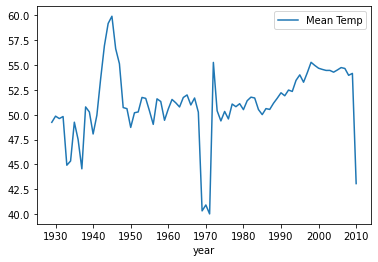

In [109]:
%%time
## Let's suppose we want the average temperature by year
data_pandas = data_parquet.groupBy("year").agg(F.mean("mean_temp").alias("Mean Temp")).toPandas()
data_pandas.sort_values("year").set_index("year").plot()

In [108]:
data_parquet.groupBy("year").agg(F.mean("mean_temp").alias("Mean Temp")).count()

82

CPU times: user 73.3 ms, sys: 18.3 ms, total: 91.7 ms
Wall time: 8.58 s


<AxesSubplot:xlabel='year'>

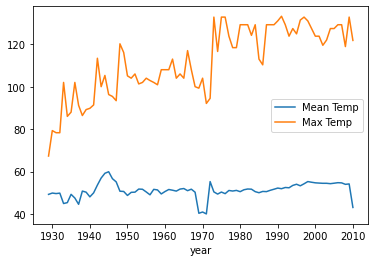

In [110]:
%%time
## Let's suppose we want more than one
data_pandas = data_parquet.groupBy("year").agg(F.mean("mean_temp").alias("Mean Temp"), 
                                               F.max("max_temperature").alias("Max Temp")).toPandas()
data_pandas.sort_values("year").set_index("year").plot()

CPU times: user 98.5 ms, sys: 36.6 ms, total: 135 ms
Wall time: 6.93 s


<AxesSubplot:xlabel='year'>

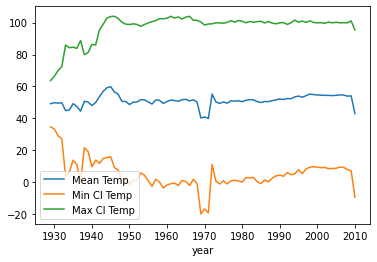

In [111]:
%%time
## Let's suppose we want more than one
data_pandas = data_parquet.groupBy("year").agg(F.mean("mean_temp").alias("Mean Temp"), 
                                               F.stddev("mean_temp").alias("SD Mean Temp")).toPandas()
data_pandas = data_pandas.sort_values("year").set_index("year")
data_pandas['Min CI Temp'] = data_pandas['Mean Temp'] - 2*data_pandas['SD Mean Temp']
data_pandas['Max CI Temp'] = data_pandas['Mean Temp'] + 2*data_pandas['SD Mean Temp']
del data_pandas['SD Mean Temp']
data_pandas.plot()

In [112]:
%%time
## Let's suppose we want more than one
data_parquet.groupBy(["year", 'month']).agg(F.mean("mean_temp").alias("Mean Temp"), 
                                               F.stddev("mean_temp").alias("SD Mean Temp")).sort(['year','month']).show()

+----+-----+------------------+------------------+
|year|month|         Mean Temp|      SD Mean Temp|
+----+-----+------------------+------------------+
|1929|    8|60.552419416366085|3.1990462574283702|
|1929|    9| 61.32605038170053|  4.03357642577158|
|1929|   10| 50.62124188117732|  4.80196415792147|
|1929|   11|47.099176249747615| 6.103062771817112|
|1929|   12| 45.37819060909536| 6.024023504130773|
|1930|    1|  44.1638498261501| 4.924192609845938|
|1930|    2| 39.85389948800284| 5.424807085849542|
|1930|    3|43.270230277588496|  6.20364872795214|
|1930|    4| 46.59947278336188| 4.285578098496348|
|1930|    5| 51.23745814294719| 5.852503116538371|
|1930|    6|57.698947384482935| 4.381964851854147|
|1930|    7| 58.29831368123098|3.4151141395515623|
|1930|    8| 58.91847454006389| 4.035375986521117|
|1930|    9| 57.15355978042948|  5.05659012503392|
|1930|   10|51.519968809464046| 4.618773602848772|
|1930|   11| 46.13617694547391| 6.240501759905245|
|1930|   12|44.314175671899264|

## User Defined Functions

In [113]:
## Let's recall how we created the time column from before
data_parquet_time = data_parquet.withColumn("time", 
                                F.concat(F.col("year"), 
                                F.lit("-"), F.col("month"), 
                                F.lit("-"), F.col("day")) \
                                .cast(types.TimestampType()))

In [114]:
%%time
data_parquet_time.select('time').show(5)

+-------------------+
|               time|
+-------------------+
|1933-06-25 00:00:00|
|1933-04-06 00:00:00|
|1933-02-20 00:00:00|
|1934-05-20 00:00:00|
|1935-11-18 00:00:00|
+-------------------+
only showing top 5 rows

CPU times: user 2.69 ms, sys: 599 µs, total: 3.29 ms
Wall time: 492 ms


In [115]:
## Can we do it differently? Yes! UDF. You can create UDF that will work row by row in your dataframe
def create_date_from_parts(year, month, day):
    return f'{year}-{month}-{day}'

create_date_udf = F.udf(create_date_from_parts, types.StringType())
data_parquet_time_udf = data_parquet.withColumn("time", create_date_udf('year', 'month', 'day').cast(types.TimestampType()))

In [118]:
%%time
data_parquet_time_udf.select('time').show(5)

+-------------------+
|               time|
+-------------------+
|1933-06-25 00:00:00|
|1933-04-06 00:00:00|
|1933-02-20 00:00:00|
|1934-05-20 00:00:00|
|1935-11-18 00:00:00|
+-------------------+
only showing top 5 rows

CPU times: user 3.48 ms, sys: 0 ns, total: 3.48 ms
Wall time: 372 ms


UDFs are typically much slower than built-in Spark functionality. The reason for this is becauase they have to serialize and deserialize the data for every row that the function is applied to. There have been recent improvements to UDF for some analytical results with Pandas UDFs that return scalars or groupby maps. Some more information about why UDFs are inefficent can be found here https://blog.cloudera.com/blog/2017/02/working-with-udfs-in-apache-spark/

In [119]:
%%time
## Let's look at other examples
from pyspark.sql.functions import udf
@udf("double")
def squared_udf(s):
    return s * s


data_udf = data_parquet.withColumn("square_temp", squared_udf(F.col("mean_temp")))
data_udf.select("square_temp").show()

+------------------+
|       square_temp|
+------------------+
| 4329.640401611337|
|1576.0900605773932|
|            240.25|
|3994.2400964355475|
| 449.4400323486334|
|            6561.0|
|           2162.25|
|           3422.25|
|             784.0|
|            2025.0|
|2190.2399285888678|
| 4733.440419921884|
|            2704.0|
|5565.1597723388695|
| 3504.640090332032|
| 3047.040084228516|
| 5169.610219421389|
| 5975.290471801767|
|            3844.0|
| 6674.889501342783|
+------------------+
only showing top 20 rows

CPU times: user 7.59 ms, sys: 4.22 ms, total: 11.8 ms
Wall time: 449 ms


In [120]:
%%time
data_no_udf = data_parquet.withColumn("square_temp", F.col("mean_temp")**2)
data_udf.select("square_temp").show()

+------------------+
|       square_temp|
+------------------+
| 4329.640401611337|
|1576.0900605773932|
|            240.25|
|3994.2400964355475|
| 449.4400323486334|
|            6561.0|
|           2162.25|
|           3422.25|
|             784.0|
|            2025.0|
|2190.2399285888678|
| 4733.440419921884|
|            2704.0|
|5565.1597723388695|
| 3504.640090332032|
| 3047.040084228516|
| 5169.610219421389|
| 5975.290471801767|
|            3844.0|
| 6674.889501342783|
+------------------+
only showing top 20 rows

CPU times: user 5.73 ms, sys: 262 µs, total: 6 ms
Wall time: 396 ms


In [126]:
%%time
## You can also use UDF with select
data_parquet.select("mean_temp", squared_udf("mean_temp").alias("squared_temp")).show()

+------------------+------------------+
|         mean_temp|      squared_temp|
+------------------+------------------+
| 65.80000305175781| 4329.640401611337|
| 39.70000076293945|1576.0900605773932|
|             -15.5|            240.25|
| 63.20000076293945|3994.2400964355475|
|21.200000762939453| 449.4400323486334|
|              81.0|            6561.0|
|              46.5|           2162.25|
|              58.5|           3422.25|
|              28.0|             784.0|
|              45.0|            2025.0|
| 46.79999923706055|2190.2399285888678|
| 68.80000305175781| 4733.440419921884|
|              52.0|            2704.0|
|  74.5999984741211|5565.1597723388695|
| 59.20000076293945| 3504.640090332032|
| 55.20000076293945| 3047.040084228516|
|  71.9000015258789| 5169.610219421389|
| 77.30000305175781| 5975.290471801767|
|              62.0|            3844.0|
| 81.69999694824219| 6674.889501342783|
+------------------+------------------+
only showing top 20 rows

CPU times: use

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


# Spark SQL

Finally, let's work with Spark SQL. Spark allows us to combine the power of SQL with Spark and the Dataframes API

In [128]:
%%time
## Let's run an example
# First we need to create a temporary table that we can query
data_parquet.registerTempTable('data')
spark.sql(
"""
select mean_temp
from data
""").show()

+------------------+
|         mean_temp|
+------------------+
| 65.80000305175781|
| 39.70000076293945|
|             -15.5|
| 63.20000076293945|
|21.200000762939453|
|              81.0|
|              46.5|
|              58.5|
|              28.0|
|              45.0|
| 46.79999923706055|
| 68.80000305175781|
|              52.0|
|  74.5999984741211|
| 59.20000076293945|
| 55.20000076293945|
|  71.9000015258789|
| 77.30000305175781|
|              62.0|
| 81.69999694824219|
+------------------+
only showing top 20 rows

CPU times: user 3.76 ms, sys: 0 ns, total: 3.76 ms
Wall time: 427 ms


In [129]:
%%time
data_parquet.select("mean_temp").show()

+------------------+
|         mean_temp|
+------------------+
| 65.80000305175781|
| 39.70000076293945|
|             -15.5|
| 63.20000076293945|
|21.200000762939453|
|              81.0|
|              46.5|
|              58.5|
|              28.0|
|              45.0|
| 46.79999923706055|
| 68.80000305175781|
|              52.0|
|  74.5999984741211|
| 59.20000076293945|
| 55.20000076293945|
|  71.9000015258789|
| 77.30000305175781|
|              62.0|
| 81.69999694824219|
+------------------+
only showing top 20 rows

CPU times: user 3.18 ms, sys: 721 µs, total: 3.91 ms
Wall time: 371 ms


In [130]:
## Let's run multiple querys similar to the ones we ran before
spark.sql(
"""
select mean_temp, power(mean_temp, 2) as squared_temp
from data
""").show()

+------------------+------------------+
|         mean_temp|      squared_temp|
+------------------+------------------+
| 65.80000305175781| 4329.640401611337|
| 39.70000076293945|1576.0900605773932|
|             -15.5|            240.25|
| 63.20000076293945|3994.2400964355475|
|21.200000762939453| 449.4400323486334|
|              81.0|            6561.0|
|              46.5|           2162.25|
|              58.5|           3422.25|
|              28.0|             784.0|
|              45.0|            2025.0|
| 46.79999923706055|2190.2399285888678|
| 68.80000305175781| 4733.440419921884|
|              52.0|            2704.0|
|  74.5999984741211|5565.1597723388695|
| 59.20000076293945| 3504.640090332032|
| 55.20000076293945| 3047.040084228516|
|  71.9000015258789| 5169.610219421389|
| 77.30000305175781| 5975.290471801767|
|              62.0|            3844.0|
| 81.69999694824219| 6674.889501342783|
+------------------+------------------+
only showing top 20 rows



In [132]:
%%time
## Let's run multiple querys similar to the ones we ran before
spark.sql(
"""
select 
    year, 
    month, 
    avg(mean_temp) as mean, 
    std(mean_temp) as st_dev
from 
    data
group by
    year,
    month
order by
    year,
    month
""").show()

+----+-----+------------------+------------------+
|year|month|              mean|            st_dev|
+----+-----+------------------+------------------+
|1929|    8|60.552419416366085|3.1990462574283702|
|1929|    9| 61.32605038170053|  4.03357642577158|
|1929|   10| 50.62124188117732|  4.80196415792147|
|1929|   11|47.099176249747615| 6.103062771817112|
|1929|   12| 45.37819060909536| 6.024023504130773|
|1930|    1|  44.1638498261501| 4.924192609845938|
|1930|    2| 39.85389948800284| 5.424807085849542|
|1930|    3|43.270230277588496|  6.20364872795214|
|1930|    4| 46.59947278336188| 4.285578098496348|
|1930|    5| 51.23745814294719| 5.852503116538371|
|1930|    6|57.698947384482935| 4.381964851854147|
|1930|    7| 58.29831368123098|3.4151141395515623|
|1930|    8| 58.91847454006389| 4.035375986521117|
|1930|    9| 57.15355978042948|  5.05659012503392|
|1930|   10|51.519968809464046| 4.618773602848772|
|1930|   11| 46.13617694547391| 6.240501759905245|
|1930|   12|44.314175671899264|

In [133]:
## We can save the Spark SQL query as a dataframe
df_sql = spark.sql(
"""
select 
    year, 
    month, 
    avg(mean_temp) as mean, 
    std(mean_temp) as st_dev
from 
    data
group by
    year,
    month
order by
    year,
    month
""")

df_sql_pd = df_sql.toPandas()
df_sql_pd = df_sql_pd.set_index(["year", 'month'])
df_sql_pd

mean     st_dev
year month                      
1929 8      60.552419   3.199046
     9      61.326050   4.033576
     10     50.621242   4.801964
     11     47.099176   6.103063
     12     45.378191   6.024024
...               ...        ...
2009 12     39.834150  26.892829
2010 1      37.385471  28.259400
     2      39.672241  27.192215
     3      46.851747  23.391840
     4      53.084282  20.170773

[969 rows x 2 columns]

In [135]:
%%time
## Let's also join dataframes
stations = spark.read.format('bigquery') \
  .option('table', 'bigquery-public-data:noaa_gsod.stations') \
  .load()

stations_us = stations.filter(F.col('Country')=='US')

## One of the dataframes is quite small, so let's broadcast it!
# join_data = data_parquet.join(F.broadcast(stations_us), stations_us.usaf==data_parquet.station_number, 'inner')
join_data = data_parquet.join(stations_us, stations_us.usaf==data_parquet.station_number, 'inner')
join_data.count()

CPU times: user 19.4 ms, sys: 3.3 ms, total: 22.7 ms
Wall time: 16.5 s


4584888375

In [84]:
join_data.printSchema()

root
 |-- station_number: long (nullable = true)
 |-- wban_number: long (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- day: long (nullable = true)
 |-- mean_temp: double (nullable = true)
 |-- num_mean_temp_samples: long (nullable = true)
 |-- mean_dew_point: double (nullable = true)
 |-- num_mean_dew_point_samples: long (nullable = true)
 |-- mean_sealevel_pressure: double (nullable = true)
 |-- num_mean_sealevel_pressure_samples: long (nullable = true)
 |-- mean_station_pressure: double (nullable = true)
 |-- num_mean_station_pressure_samples: long (nullable = true)
 |-- mean_visibility: double (nullable = true)
 |-- num_mean_visibility_samples: long (nullable = true)
 |-- mean_wind_speed: double (nullable = true)
 |-- num_mean_wind_speed_samples: long (nullable = true)
 |-- max_sustained_wind_speed: double (nullable = true)
 |-- max_gust_wind_speed: double (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- max_temperatu

In [89]:
%%time
## let's now use Spark SQL to query this data
join_data.registerTempTable('data')
spark.sql(
"""
select 
    state,
    avg(mean_temp) as mean, 
    avg(lat),
    avg(lon)
from 
    data
where
    state in ('CA', 'TX', 'NY')
group by
    state
order by
    state
""").show()

+-----+-----------------+------------------+-------------------+
|state|             mean|          avg(lat)|           avg(lon)|
+-----+-----------------+------------------+-------------------+
|   CA|53.74720653195868|35.892474221332854|-119.49590372037532|
|   NY|53.66972249742794|42.229195093361426| -76.01350616490826|
|   TX|53.81268076536834|30.791588006368688| -98.54278344659757|
+-----+-----------------+------------------+-------------------+

CPU times: user 16 ms, sys: 5.76 ms, total: 21.7 ms
Wall time: 42.8 s
